#INFO
experiments that can take place :





1.   changing BERT from pretrained from base-uncased to bertweet
2.   keeping or omitting verified
3.   trainig pairs of (source , reply) , (source-tag) 
4.   add source aggregated (known stance)

source_reply_*.json format last used




##setup


In [ ]:
import tensorflow as tf
import torch
import os
import pandas as pd
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
import matplotlib.pyplot as plt
% matplotlib inline
import json
import seaborn as sns
from sklearn.metrics import matthews_corrcoef

     |████████████████████████████████| 1.3MB 5.8MB/s 
     |████████████████████████████████| 890kB 35.7MB/s 
     |████████████████████████████████| 2.9MB 38.8MB/s 
     |████████████████████████████████| 1.1MB 38.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9e12a80b30d5607d4592af5085c2c848da31a5f69a96cd785a4c8dcd4ab90701
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
!pip3 install emoji

     |████████████████████████████████| 51kB 4.1MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=c9cdd9c14d297f7de378344c13b5c6417103b7b13c46da68df7c08cb7ad7132b
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [ ]:
a=np.array([[[1,2],[1,2]],[[1,2],[1,2]],[[1,2],[1,2]]])
flat_predictions = np.concatenate(a, axis=0)
flat_predictions.shape

(6, 2)

## loading data


In [ ]:
!git clone "https://github.com/parsafarinnia/rumoureval2019"

Cloning into 'rumoureval2019'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 70 (delta 29), reused 44 (delta 13), pack-reused 0
Unpacking objects: 100% (70/70), done.


### Loading source - aggregated stance(from key)
format is {sourceId : [s,d,q,c]}

In [ ]:
import pickle
source_stance_train = pickle.load(open ("/content/rumoureval2019/source_stance_train.p","rb"))
source_stance_dev = pickle.load(open ("/content/rumoureval2019/source_stance_dev.p","rb"))
source_stance_test = pickle.load(open ("/content/rumoureval2019/source_stance_test.p","rb"))

### preprocessed clean data (Sardar's)

In [ ]:
with open('/content/rumoureval2019/rum_ver_stance_dev') as f:
  data = json.load(f)
dev_cleaned=pd.DataFrame.from_dict(data)
dev_cleaned

FileNotFoundError: ignored

In [ ]:
with open('/content/rumoureval2019/rum_ver_stance_train') as f:
  data = json.load(f)
train_cleaned=pd.DataFrame.from_dict(data)
train_cleaned.veracitytag.unique()

In [ ]:
map= {"Rum":1,"unverified":2,"na":0}
train_parent_child = train_cleaned[['text','parent_body','rum_tag']]
dev_parent_child = dev_cleaned[['text','parent_body','rum_tag']]
train_parent_child=train_parent_child.replace({"rum_tag":map})
dev_parent_child = dev_parent_child.replace({"rum_tag":map})
dev_parent_child

### parsa preprocessing

In [ ]:
with open('/content/rumoureval2019/source_reply_dev.json') as f:
  data = json.load(f)
dev_cleaned=pd.DataFrame.from_dict(data)
with open('/content/rumoureval2019/source_reply_test.json') as f1:
  data = json.load(f1)
test_cleaned=pd.DataFrame.from_dict(data)
with open('/content/rumoureval2019/source_reply_train.json') as f2:
  data = json.load(f2)
train_cleaned=pd.DataFrame.from_dict(data)
map= {'unverified':1, 'true':2, 'false':0}
train_parent_child=train_cleaned.replace({"class":map})
dev_parent_child = dev_cleaned.replace({"class":map})
test_parent_child = test_cleaned.replace({"class":map})
test_parent_child.groupby(['source_text']).mean().shape

### normal not preprocessed data(only sources work now)

In [ ]:
train = pd.read_json("/content/rumoureval2019/train.json")
# train = train.drop(train[train['class']=='unverified'].index)
train

,text,class
500288349924782080,Did anyone think of comparing the clothes that...,unverified
500308076004929537,"Possible ""robbery"" took place and BAM! Like ma...",unverified
544282227035869184,BREAKING NEWS: Gunmen take hostages at Sydney ...,true
529695367680761856,OMG. #Prince rumoured to be performing in Toro...,false
544324444773433348,"Uber says it has hiked prices in Sydney to ""en...",true
...,...,...
8gp0d7,[Serious] Is it true that 85% of people can on...,true
8i274x,Did Eric Schneiderman Help NXIVM Sell Child Se...,false
8n9173,Debunk this: The direction you sleep matters,false
8unvgg,Is it true police officers must hit a quota at...,false


In [ ]:
dev = pd.read_json("/content/rumoureval2019/dev.json")
# dev = dev.drop(dev[dev['class']=='unverified'].index)
dev

,text,class
775057555865206784,What do you think Hillary is suffering from?,false
498486826269548545,.@AP I demand you retract the lie that people ...,unverified
774991078265094144,"Except for the coughing, fainting, apparent se...",false
524948206023880704,The latest @CBCNews on #Ottawa shootings. Gunm...,true
769988636754505729,267 days since Sick Hillary had a press confer...,false
544315472075042818,US consulate in #Sydney reportedly evacuated a...,unverified
524936793633083394,Very tense situation in Ottawa this morning. ...,true
553561170637238272,BREAKING: Police order all shops closed in fam...,unverified
763098277986209792,Hillary Mystery Handler Spotted With Diazepam ...,false
498293668655423488,Every 28 hours a black male is killed in the U...,unverified


In [ ]:
test = pd.read_json("/content/rumoureval2019/test.json")
test

,text,class
443938194715713536,Rep. Sheila Jackson Lee has no shame. I still ...,true
774165935041093633,"ICYMI: ""Rep Sheila Jackson Lee (D-Tx) Wants Hu...",true
784071228248109057,Clinton camp delays Weather Channel ad buy aft...,true
784118929799073793,Clinton camp delays Weather Channel ad buy aft...,true
784216706080178176,Clinton camp delays Weather Channel ad buy aft...,true
...,...,...
8m9y0o,People who can't smell. Is it true that there ...,true
938o5h,Great Pyramid of Giza can focus electromagneti...,true
ayn70,Is it true that the federal government require...,false
wfajw,Is it true Romney has Caymen bank accounts?,true


In [ ]:
# mapping categorical to numerical
map= {"true":1,"unverified":2,"false":0}
train=train.replace({"class":map})
train

,text,class
500288349924782080,Did anyone think of comparing the clothes that...,2
500308076004929537,"Possible ""robbery"" took place and BAM! Like ma...",2
544282227035869184,BREAKING NEWS: Gunmen take hostages at Sydney ...,1
529695367680761856,OMG. #Prince rumoured to be performing in Toro...,0
544324444773433348,"Uber says it has hiked prices in Sydney to ""en...",1
...,...,...
8gp0d7,[Serious] Is it true that 85% of people can on...,1
8i274x,Did Eric Schneiderman Help NXIVM Sell Child Se...,0
8n9173,Debunk this: The direction you sleep matters,0
8unvgg,Is it true police officers must hit a quota at...,0


In [ ]:
test=test.replace({"class":map})
dev=dev.replace({"class":map})


### importing saved vectorized data

In [ ]:
import pickle
bert_tweet_vecs = pickle.load( open( "/content/rumoureval2019/bert_tweet_vecs.p", "rb" ) )
train_features=bert_tweet_vecs['train']
dev_features=bert_tweet_vecs['dev']
test_features=bert_tweet_vecs['test']

### final data for train dev test 

#### parsa cleaned data


In [ ]:
'''
if preprocessed by parsa
'''
train_sources=train_parent_child.source_text.values
train_comments=train_parent_child.reply_text.values
train_labels=train_parent_child['class'].values
dev_sources = dev_parent_child.source_text.values
dev_comments = dev_parent_child.reply_text.values
dev_labels = dev_parent_child['class'].values
test_sources = test_parent_child.source_text.values
test_comments = test_parent_child.reply_text.values
test_labels = test_parent_child['class'].values

NameError: ignored

In [ ]:
train_sources=np.reshape(train_sources,(len(train_sources),1))
train_comments=np.reshape(train_comments,(len(train_comments),1))
train_data=np.concatenate([train_sources,train_comments],axis=1)
dev_sources=np.reshape(dev_sources,(len(dev_sources),1))
dev_comments=np.reshape(dev_comments,(len(dev_comments),1))
dev_data=np.concatenate([dev_sources,dev_comments],axis=1)
test_sources=np.reshape(test_sources,(len(test_sources),1))
test_comments=np.reshape(test_comments,(len(test_comments),1))
test_data=np.concatenate([test_sources,test_comments],axis=1)

#### by others
sardars and source only tweet

In [ ]:
'''
if not preprocessed
'''
train_sentences=train.text.values
train_labels = train["class"].values
test_sentences=test.text.values
test_labels = test["class"].values
dev_sentences=dev.text.values
dev_labels = dev["class"].values
'''
if preprocessed by sardar
'''
# train_sources=train_parent_child.parent_body.values
# train_comments=train_parent_child.text.values
# train_labels=train_parent_child.rum_tag.values
# dev_sources = dev_parent_child.parent_body.values
# dev_comments = dev_parent_child.text.values
# dev_labels = dev_parent_child.rum_tag.values
'''
from sklearn.model_selection import train_test_split
train_sources=np.reshape(train_sources,(len(train_sources),1))
train_comments=np.reshape(train_comments,(len(train_comments),1))
train_data=np.concatenate([train_sources,train_comments],axis=1)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2)
dev_sources=np.reshape(dev_sources,(len(dev_sources),1))
dev_comments=np.reshape(dev_comments,(len(dev_comments),1))
test_data=np.concatenate([dev_sources,dev_comments],axis=1)
'''



'\nfrom sklearn.model_selection import train_test_split\ntrain_sources=np.reshape(train_sources,(len(train_sources),1))\ntrain_comments=np.reshape(train_comments,(len(train_comments),1))\ntrain_data=np.concatenate([train_sources,train_comments],axis=1)\ntrain_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2)\ndev_sources=np.reshape(dev_sources,(len(dev_sources),1))\ndev_comments=np.reshape(dev_comments,(len(dev_comments),1))\ntest_data=np.concatenate([dev_sources,dev_comments],axis=1)\n'

In [ ]:
train_ids=train.index.values
dev_ids=dev.index.values
test_ids=test.index.values

In [ ]:
#rearrange train stance
rearranged_list_train=[]
for train_id in train_ids:
  rearranged_list_train.append(source_stance_train[train_id])
rearranged_list_dev=[]
for train_id in dev_ids:
  rearranged_list_dev.append(source_stance_dev[train_id])
rearranged_list_test=[]
for train_id in test_ids:
  rearranged_list_test.append(source_stance_test[train_id])

In [ ]:

train_labels_hv=[]
for label in train['class'].values:
  dummy=[0,0,0]
  dummy[label]=1
  train_labels_hv.append(dummy)
test_labels_hv=[]
for label in test['class'].values:
  dummy=[0,0,0]
  dummy[label]=1
  test_labels_hv.append(dummy)
dev_labels_hv=[]
for label in dev['class'].values:
  dummy=[0,0,0]
  dummy[label]=1
  dev_labels_hv.append(dummy)



In [ ]:
stance_train=np.array(rearranged_list_train)
stance_dev=np.array(rearranged_list_dev)
stance_test=np.array(rearranged_list_test)
train_labels_hv=np.array(train_labels_hv)
dev_labels_hv=np.array(dev_labels_hv)
test_labels_hv=np.array(test_labels_hv)
print(stance_train.shape)
print(train_labels_hv.shape)
print(stance_dev.shape)
print(dev_labels_hv.shape)
print(stance_test.shape)
print(test_labels_hv.shape)

(327, 4)
(327, 3)
(38, 4)
(38, 3)
(81, 4)
(81, 3)


## loading berts




In [ ]:
from transformers import AutoModel, AutoTokenizer 
# Load BERT TWEET tokenizer and model
bert_tweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer_tweet = AutoTokenizer.from_pretrained("vinai/bertweet-base",normalization=True)
# bert_tweet = AutoModel.from_pretrained("bert-base-uncased")
# tokenizer_tweet = AutoTokenizer.from_pretrained("bert-base-uncased",normalization=True)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


#Training

## Naive bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
x=np.concatenate([train_features,dev_features])
x_stance=np.concatenate([stance_train,stance_dev])
x=np.concatenate([x,x_stance],axis=1)
y=np.concatenate([train_labels,dev_labels])
x_test=np.concatenate([test_features,stance_test],axis=1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x)
x=scaler.transform(x)
x_test=scaler.transform(x_test)
clf = MultinomialNB()
clf.fit(x, y)
y_pred=clf.predict(x_test)
print(classification_report(test_labels, y_pred, labels=[0,1,2]))



              precision    recall  f1-score   support

           0       0.46      0.80      0.58        40
           1       0.00      0.00      0.00        31
           2       0.22      0.20      0.21        10

    accuracy                           0.42        81
   macro avg       0.23      0.33      0.26        81
weighted avg       0.25      0.42      0.31        81



## random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
clf = RandomForestClassifier( random_state=0)
x=np.concatenate([train_features,dev_features])
x_stance=np.concatenate([stance_train,stance_dev])
x=np.concatenate([x,x_stance],axis=1)
y=np.concatenate([train_labels,dev_labels])
x_test=np.concatenate([test_features,stance_test],axis=1)
clf.fit(x, y)
y_pred=clf.predict(x_test)
print(classification_report(test_labels, y_pred, labels=[0,1,2]))


              precision    recall  f1-score   support

           0       0.50      0.68      0.57        40
           1       0.22      0.13      0.16        31
           2       0.11      0.10      0.11        10

    accuracy                           0.40        81
   macro avg       0.28      0.30      0.28        81
weighted avg       0.35      0.40      0.36        81



## SVM

In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report
clf = svm.SVC()
x=np.concatenate([train_features,dev_features])
x_stance=np.concatenate([stance_train,stance_dev])
x=np.concatenate([x,x_stance],axis=1)
y=np.concatenate([train_labels,dev_labels])
x_test=np.concatenate([test_features,stance_test],axis=1)
clf.fit(x,y)
y_pred=clf.predict(x_test)
print(classification_report(test_labels, y_pred, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.61      0.28      0.38        40
           1       0.44      0.84      0.58        31
           2       0.00      0.00      0.00        10

    accuracy                           0.46        81
   macro avg       0.35      0.37      0.32        81
weighted avg       0.47      0.46      0.41        81



In [ ]:

clf = BaggingClassifier(base_estimator=svm.SVC(),n_estimators=15, random_state=0)
clf.fit(x,y)
y_pred=clf.predict(x_test)
print(classification_report(test_labels, y_pred, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.62      0.25      0.36        40
           1       0.43      0.84      0.57        31
           2       0.00      0.00      0.00        10

    accuracy                           0.44        81
   macro avg       0.35      0.36      0.31        81
weighted avg       0.47      0.44      0.39        81



### knn bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
clf = BaggingClassifier(KNeighborsClassifier(3),max_samples=0.5, max_features=0.5)
x=np.concatenate([train_features,dev_features])
x_stance=np.concatenate([stance_train,stance_dev])
x=np.concatenate([x,x_stance],axis=1)
y=np.concatenate([train_labels,dev_labels])
x_test=np.concatenate([test_features,stance_test],axis=1)
clf.fit(x,y)
y_pred=clf.predict(x_test)
print(classification_report(test_labels, y_pred, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.54      0.50      0.52        40
           1       0.45      0.45      0.45        31
           2       0.15      0.20      0.17        10

    accuracy                           0.44        81
   macro avg       0.38      0.38      0.38        81
weighted avg       0.46      0.44      0.45        81



### tokenizer

#### source - comment bert

In [ ]:
#tokenizer for 2 sentence input

def two_sentence_tokenizer_func(tokenizer_kind,sentences,labels):
  '''
  inputs:
    tokenizer_kind: is the the tokenizer of choice (normal bert, tweet bert)  
    sentences: train , dev, test
  outputs:
  torchs of 
    ids
    attention_mask
    labels
  '''
  input_ids = []
  attention_masks = []
  # For every sentence...
  for pair in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer_kind(
                          pair[0],pair[1],                     # Sentence to encode.
                          return_tensors = 'pt',     # Return pytorch tensors.
                          padding='max_length',
                          truncation=True
                          
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.

  # input_ids = torch.FloatTensor(input_ids)
  # print(input_ids[0].shape)
  # attention_masks = torch.FloatTensor(attention_masks)
  # print(attention_masks)
  # labels = torch.tensor(labels)
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks ,labels


#### source only bert

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
def tokenizer_func(tokenizer_kind,sentences,labels):
  '''
  inputs:
    tokenizer_kind: is the the tokenizer of choice (normal bert, tweet bert)  
    sentences: train , dev, test
  outputs:
  torchs of 
    ids
    attention_mask
    labels
  '''
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer_kind.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 128,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                          truncation=True,
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks ,labels
  # Print sentence 0, now as a list of IDs.


#### data loader


In [ ]:
#two sentence source comment

# train_input_ids,train_attention_masks,train_labels=two_sentence_tokenizer_func(tokenizer_tweet,train_data,train_labels)
# val_input_ids,val_attention_masks,val_labels=two_sentence_tokenizer_func(tokenizer_tweet,dev_data,dev_labels)

#source only
train_input_ids,train_attention_masks,train_labels=tokenizer_func(tokenizer_tweet,train_sentences,train_labels)
dev_input_ids,dev_attention_masks,dev_labels=tokenizer_func(tokenizer_tweet,dev_sentences,dev_labels)
test_input_ids,test_attention_masks,test_labels=tokenizer_func(tokenizer_tweet,test_sentences,test_labels)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
# test_dataloader=DataLoader(
#     test_dataset,
#     sampler = SequentialSampler(test_dataset),
#     batch_size = batch_size
# )

##stance aggregated source , merge model

In [ ]:
train_input_ids,train_attention_masks,train_labels=tokenizer_func(tokenizer_tweet,train_sentences,train_labels)
dev_input_ids,dev_attention_masks,dev_labels=tokenizer_func(tokenizer_tweet,dev_sentences,dev_labels)
test_input_ids,test_attention_masks,test_labels=tokenizer_func(tokenizer_tweet,test_sentences,test_labels)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### Vectorizing train test dev

In [ ]:
t0 = time.time()
# bert_tweet.cuda()
bert_tweet.eval()
with torch.no_grad():
  # batch = tuple(t.to(device) for t in batch)
  last_hidden_states_train = bert_tweet(train_input_ids, attention_mask=train_attention_masks)
  train_features = last_hidden_states_train[0][:,0,:].numpy()
  print('train done')
  last_hidden_states_dev = bert_tweet(dev_input_ids, attention_mask=dev_attention_masks)
  dev_features = last_hidden_states_dev[0][:,0,:].numpy()
  print('dev done')
  last_hidden_states_test = bert_tweet(test_input_ids, attention_mask=test_attention_masks)
  test_features = last_hidden_states_test[0][:,0,:].numpy()
  print('test done')
elapsed = format_time(time.time() - t0)
print(elapsed)

train done
dev done
test done


NameError: ignored

In [ ]:
bert_tweet_vecs={"train":train_features,"dev":dev_features,"test":test_features}
pickle.dump( bert_tweet_vecs, open( "bert_tweet_vecs.p", "wb" ) )

### defining  architucture

In [ ]:
from sklearn.metrics import f1_score
def f1_h(y_true,y_pred):
  y_true_int=np.argmax(y_true,axis=1)
  y_pred_int=np.argmax(y_pred,axis=1)
  macro=f1_score(y_true_int, y_pred_int, average='macro')
  return macro


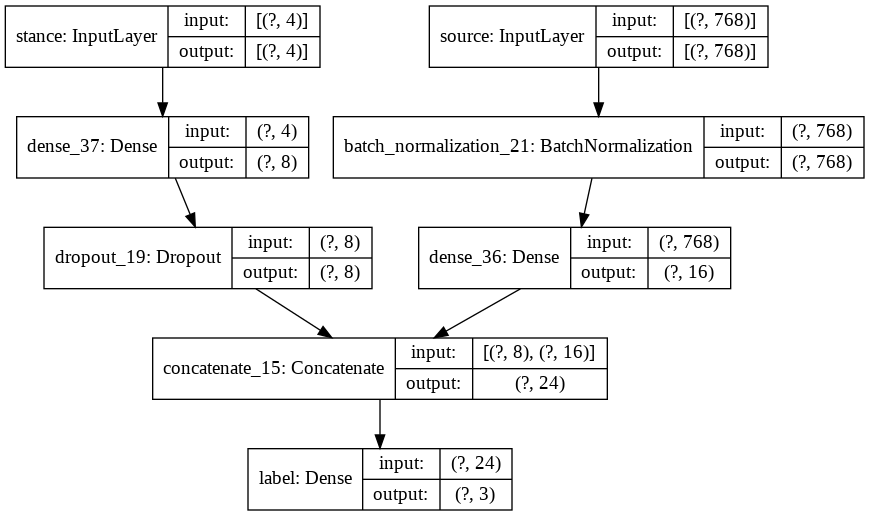

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.normalization import BatchNormalization
source_input = keras.Input(shape=(768,),name="source")
source_input1=BatchNormalization()(source_input)
source_dense = layers.Dense(16,activation="tanh")
source_out = source_dense(source_input1)
# source_output = source_dense(source_dropped_out)
DO_layer_stance = tf.keras.layers.Dropout(.4, input_shape=(8,))
stance_input = keras.Input(shape=(4,),name="stance")
stance_dense = layers.Dense(8,activation="linear")
stance_output1= stance_dense(stance_input)
stance_output = DO_layer_stance(stance_output1)
concated_input1 = layers.concatenate([stance_output,source_out])
label=layers.Dense(3,activation="softmax",name="label")
verification_prediction=label(concated_input1)
combined_model=keras.Model(inputs=[source_input,stance_input],outputs=[verification_prediction])
keras.utils.plot_model(combined_model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
from keras.callbacks import ModelCheckpoint
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
combined_model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(lr=0.0001),
    metrics=["accuracy"],
)
# checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
history = combined_model.fit({"source":train_features,"stance":stance_train},train_labels_hv, batch_size=16, epochs=500, validation_data=({"source":dev_features,"stance":stance_dev},dev_labels_hv), callbacks=my_callbacks)

# test_scores = combined_model.evaluate({"source":test_features,"stance":stance_test},test_labels_hv, verbose=2)

y_pred_test=combined_model.predict({"source":test_features,"stance":stance_test})
y_pred_dev=combined_model.predict({"source":dev_features,"stance":stance_dev})
print("f1 score dev:" ,f1_h(dev_labels_hv,y_pred_dev))
print("f1 score test:" ,f1_h(test_labels_hv,y_pred_test))


Epoch 1/500
21/21 [==============================] - 0s 17ms/step - loss: 2.3560 - accuracy: 0.3211 - val_loss: 2.6511 - val_accuracy: 0.2632
Epoch 2/500
21/21 [==============================] - 0s 7ms/step - loss: 2.0119 - accuracy: 0.3333 - val_loss: 2.5991 - val_accuracy: 0.2632
Epoch 3/500
21/21 [==============================] - 0s 6ms/step - loss: 2.0585 - accuracy: 0.3792 - val_loss: 2.5454 - val_accuracy: 0.2632
Epoch 4/500
21/21 [==============================] - 0s 6ms/step - loss: 1.8363 - accuracy: 0.4312 - val_loss: 2.4854 - val_accuracy: 0.2895
Epoch 5/500
21/21 [==============================] - 0s 7ms/step - loss: 2.0684 - accuracy: 0.3547 - val_loss: 2.4343 - val_accuracy: 0.3421
Epoch 6/500
21/21 [==============================] - 0s 7ms/step - loss: 1.8622 - accuracy: 0.3976 - val_loss: 2.3843 - val_accuracy: 0.3158
Epoch 7/500
21/21 [==============================] - 0s 6ms/step - loss: 1.6739 - accuracy: 0.4281 - val_loss: 2.3426 - val_accuracy: 0.3158
Epoch 8/500


In [ ]:
combined_model.summary()

Model: "functional_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
source (InputLayer)             [(None, 768)]        0                                            
__________________________________________________________________________________________________
stance (InputLayer)             [(None, 4)]          0                                            
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 768)          3072        source[0][0]                     
__________________________________________________________________________________________________
dense_67 (Dense)                (None, 1)            5           stance[0][0]                     
______________________________________________________________________________________

##  source and source-reply only
no meta-dataa
no stance


### training


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer,AutoModelForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 20
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
print(total_steps)

420


In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 20 ========
Training...

  Average training loss: 1.24
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.44
  Validation Loss: 1.09
  Validation took: 0:00:05

======== Epoch 2 / 20 ========
Training...

  Average training loss: 1.08
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.34
  Validation Loss: 1.09
  Validation took: 0:00:05

======== Epoch 3 / 20 ========
Training...

  Average training loss: 1.09
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.44
  Validation Loss: 1.07
  Validation took: 0:00:05

======== Epoch 4 / 20 ========
Training...

  Average training loss: 1.09
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.44
  Validation Loss: 1.07
  Validation took: 0:00:05

======== Epoch 5 / 20 ========
Training...

  Average training loss: 1.08
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.44
  Validation Loss: 1.06
  Validation took: 0:00:05

======== Epoch

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.24,1.09,0.44,0:00:14,0:00:05
2,1.08,1.09,0.34,0:00:14,0:00:05
3,1.09,1.07,0.44,0:00:14,0:00:05
4,1.09,1.07,0.44,0:00:14,0:00:05
5,1.08,1.06,0.44,0:00:14,0:00:05
6,1.06,1.07,0.44,0:00:14,0:00:05
7,1.05,0.94,0.54,0:00:14,0:00:05
8,0.86,0.78,0.66,0:00:14,0:00:05
9,0.74,0.85,0.64,0:00:14,0:00:05


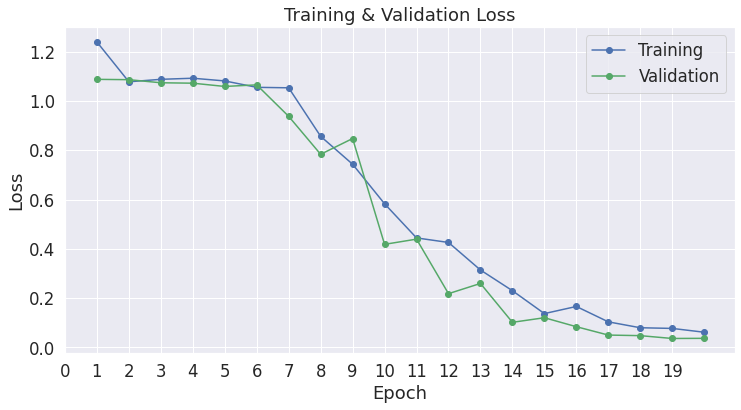

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(0,epochs))

plt.show()

## testing on test set

In [ ]:
batch_size=16
#source comment
# test_input_ids,test_attention_masks,test_labels=two_sentence_tokenizer_func(tokenizer_tweet,test_data,test_labels)
# source only
test_input_ids,test_attention_masks,test_labels=tokenizer_func(tokenizer_tweet,test_sentences,test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
%time
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()
print('Predicting labels for {:,} test batches...'.format(len(prediction_dataloader)))
# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 5.96 µs
Predicting labels for 81 test sentences...
Predicting labels for 6 test batches...


In [ ]:
len(true_labels)

6

### results and metrics

#### f1 and accuracy

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
flat_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
# with dropping unverified from train and val
from sklearn.metrics import f1_score
macro=f1_score(flat_true_labels, flat_predictions, average='macro')
micro=f1_score(flat_true_labels, flat_predictions, average='micro')
weighted=f1_score(flat_true_labels, flat_predictions, average='weighted')
print('macro f1 score: %.3f' %macro)
print('micro f1 score: %.3f' %micro)
print('weighted f1 score: %.3f' %weighted)

macro f1 score: 0.329
micro f1 score: 0.383
weighted f1 score: 0.385


#### confusion matrix

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

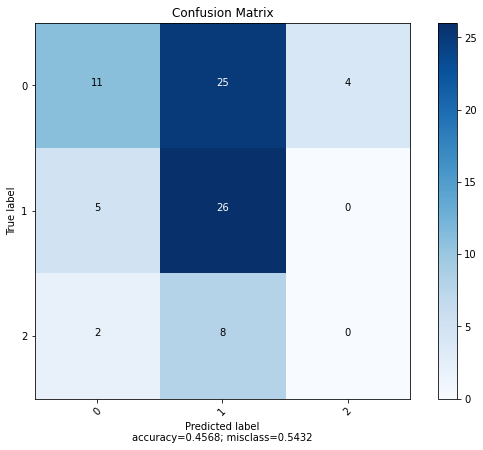

In [ ]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(cm           = confusion_matrix(test_labels, y_pred),
                      normalize    = False,
                      target_names = ['0', '1','2'],
                      title        = "Confusion Matrix")

#### pooling with reply tags for tests
counting how many reply each source has to do pooling

In [ ]:
test_cleaned.head()

,source_text,reply_text,class
443942694612508673,Rep. Sheila Jackson Lee has no shame. I still ...,@sleepdoctorjoe @instapundit America's favorit...,true
443941497541754880,Rep. Sheila Jackson Lee has no shame. I still ...,@sleepdoctorjoe @instapundit Math. Still hard ...,true
443941649555533825,Rep. Sheila Jackson Lee has no shame. I still ...,@sleepdoctorjoe @dmbatten2 She apparently also...,true
443985646969843712,Rep. Sheila Jackson Lee has no shame. I still ...,@sleepdoctorjoe @dmbatten2 ALERT!! DEM VILLAG...,true
443940443219570689,Rep. Sheila Jackson Lee has no shame. I still ...,@sleepdoctorjoe @instapundit Andrew tops that ...,true


In [ ]:

def pooling(source_texts,predicted_label):
  index=[]
  index.append(0)
  for i in range(len(source_texts)-1):
    if source_texts[i]==source_texts[i+1]:
      i+=1
    else:
      index.append(i+1)
  index.append(len(source_texts)-1)
  av=[]
  pooling_prediction = predicted_label
  for i in range(len(index)-1):
    sum=0
    for k in range(index[i],index[i+1]):
      sum+=predicted_label[k]
    av.append(sum/(index[i+1]-index[i]))
  myList =[0 , 1 ,2]
  pred_pooling=[ min(myList, key=lambda x:abs(x-av[i])) for i in range(len(av))]
  return pred_pooling

In [ ]:
from sklearn.metrics import f1_score
source_texts_labels=test_cleaned['source_text'].values
test_labels= test_parent_child['class'].values
true_labels= pooling(source_texts_labels,test_labels)
pred= pooling(source_texts_labels,flat_predictions)
macro=f1_score(true_labels, pred, average='macro')
micro=f1_score(true_labels, pred, average='micro')
print('macro f1 score: %.3f' %macro)
print('micro f1 score: %.3f' %micro)


macro f1 score: 0.124
micro f1 score: 0.148


In [ ]:
for item in true_labels:
  if item ==3:
    print(1)

# save model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer_tweet.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/bpe.codes',
 './model_save/added_tokens.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r ./model_save/ "/content/drive/MyDrive/rumour"

# Load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%time
from transformers import BertConfig, BertModel
from transformers import BertTokenizer,AutoModelForSequenceClassification 
input_saved_model_dir="/content/drive/MyDrive/rumour/comment_source"
model=AutoModelForSequenceClassification.from_pretrained(input_saved_model_dir)
# tokenizer_tweet = BertTokenizer.from_pretrained(input_saved_model_dir)

# Copy the model to the GPU.
model.to(device)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, element